Demo of the Voder Speech Synthesiser's working principles, using digital signal processing techniques.

Start with a source sound (sawtooth or white noise), and apply a filter made of multiple Gaussians.

Also make animations of spectrum plots over the course of the speech sound.

Produces the phrase "She saw me" with various expressions and emphases.

In [1]:
import sys
import os
sys.path.append('../sms-tools-enhanced/software/models/')
sys.path.append('../sms-tools-enhanced/software/transformations/')
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
import utilFunctions as UF
import sineModel as SM
import harmonicModel as HM
import dftModel as DFT
import stochasticModel as ST
import harmonicTransformations as HT
from scipy.signal import hanning, resample
from scipy.fftpack import fft, ifft
import cmath
from matplotlib import collections as matcoll
from scipy import interpolate
import matplotlib.animation as animation
from IPython.display import Audio
import scipy.io.wavfile
%matplotlib inline

In [2]:
# Citation: The code in this cell, to display animations inline, was from 
# http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/

from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=172, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

# Utility Functions

In [3]:
def decibel(amplitude):
    # Takes fourier amplitude and converts to decibels
    amplitude_dB = 20. * np.log10(amplitude/120.)
    return amplitude_dB
def inverse_decibel(amplitude_dB):
    # Takes value in decibels and converts it to original scale
    amplitude = 120.*(10**(amplitude_dB/20.))
    return amplitude

In [4]:
def interp_f(x, x_points, y_points):
    tck = interpolate.splrep(x_points, y_points)
    return interpolate.splev(x, tck)

In [5]:
def interp_time(tstart, tend, tstep, valstart, valend):
    # Gives the input variable as a function of time, given its starting and ending values
    # tstart: start time
    # tend: end time
    # tstep: time step
    # valstart: starting value
    # valend: ending value
    
    numsteps = int((tend - tstart)/tstep)
    val_func = np.zeros(numsteps + 1, dtype=float) # Value as a function of time
    for t in range (0, numsteps + 1):
        val_func[t] = valstart + t*(valend - valstart)/numsteps
    return val_func

In [143]:
def convert_amplitude(A):
    # Convert an input amplitude A between 0.0 and 1.0
    # Such that 0.0 corresponds to base in dB
    # And 1.0 corresponds to 0 dB
    
    Abase = inverse_decibel(base)
    Atop = inverse_decibel(0.)
    return A*(Atop - Abase) + base

In [6]:
def normalise_sound(x):
    # Normalise a sound array x, so that its max value is 0.95
    
    maxval = np.max(abs(x))
    y = x*0.95/maxval
    return y

# Plotting and Animation Functions

In [7]:
def spline_plot(xplot, yplot):
    # Plot a harmonic sound, with its harmonics drawn as vertical lines with circles on top,
    # And show the interpolated spectral shape as a dotted line

    f0 = xplot[0]
    fmax = 5000
    
    # Vertical lines
    lines = []
    for i in range(len(xplot)):
        pair=[(xplot[i],base), (xplot[i], yplot[i])]
        lines.append(pair)

    linecoll = matcoll.LineCollection(lines)
    fig, ax = plt.subplots(figsize=(10,4))
    ax.add_collection(linecoll)

    # Axes and labels
    plt.xticks(np.arange(f0, 26*f0, f0))
    ax.set_xticklabels(np.arange(f0, 26*f0, f0), rotation=-45, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left') 
    ax.xaxis.set_ticks_position('bottom')
    plt.yticks([])   # No y ticks
    ax.set_xlabel('Frequency (Hz)')

    plt.scatter(xplot,yplot)   # Filled circles showing height of harmonics

    xaxis = np.arange(0,fmax)
    
    # Dotted line for interpolation between circles
    plt.plot(xaxis, interp_f(xaxis, np.append(0, xplot[0:30]), np.append(base,yplot[0:30])), 'b--')
    
    plt.axis([0,fmax,base,0])
    #plt.savefig("ah_edit.jpg", bbox_inches='tight')
    plt.show()

In [155]:
def do_animation2(hfreqs, hmags, stocEnvs, dovowel, doconsonant):
    # Animation showing how the spectrum changes over the course of a sound.
    # Has two spectra plotted on the same plot:
    # The harmonic part (vowels and voiced consonants), showing the harmonics as vertical blue lines
    # And the stochastic part (unvoiced consonants), as a red line
    
    # hfreqs, hmags: frequencies and magnitudes of harmonics, for each time frame
    # stocengs: stochastic envelopes, for each time frame
    # dovowel: boolean.  If true, show harmonic plot
    # doconsonant: boolean. If true, show stochastic plot
    
    nframes = hfreqs.shape[0]
    #fformmax = 5000.
    #nH_formmax = int(fformmax/f0)
    nH_formmax = 30

    # Animation
    fig = plt.figure()
    #fig.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97, wspace=None, hspace=None)
    
    # Axes
    ax = plt.axes(xlim = (0, fformmax), ylim = (base, 20.))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left') 
    ax.xaxis.set_ticks_position('bottom')
    plt.yticks([])
    ax.set_xlabel('Frequency (Hz)')

    xaxis = np.arange(0, fformmax)

    if dovowel:
        lines = []
        points = []
        for h in range(0, nH_formmax):
            line, = ax.plot([], [], 'navy')      # vertical lines
            point = ax.scatter([], [], c = 'b')  # filled circles
            lines.append(line)
            points.append(point)
        interp, = ax.plot([], [], 'b--')         # dotted line
    if doconsonant:
        stoc, = ax.plot([], [], 'red')           # red solid line

    plots = []
    if dovowel:
        for h in range(0, nH_formmax):
            plots.append(lines[h])
            plots.append(points[h])
        plots.append(interp)
    if doconsonant:
        plots.append(stoc)

    def init():
        if dovowel:
            for h in range(0, nH_formmax):
                lines[h].set_data([],[])
                points[h].set_offsets([])
            interp.set_data([],[])
        if doconsonant:
            stoc.set_data([],[])
        return plots    
    
    def animate(t):
        if dovowel:
            for h in range(0, nH_formmax):
                xcoord = hfreqs[t,h]
                ycoord = hmags[t,h]
                #lines[h].set_data([xcoord + 10*time, xcoord + 10*time],[base, ycoord + 2*time])
                lines[h].set_data([xcoord, xcoord],[base, ycoord])
                points[h].set_offsets([xcoord, ycoord])
            interp.set_data(xaxis, interp_f(xaxis, np.append(0, hfreqs[t,:nH_formmax]), np.append(base,hmags[t,:nH_formmax])))
        if doconsonant:
            # Resample stocEnvs to have the same number of points as fs/2,
            # Then take the part that is within the plot range
            stoc.set_data(xaxis, resample(stocEnvs[t], int(fs/2))[:fformmax])
        return plots

    ann2 = animation.FuncAnimation(fig, animate, init_func=init, frames = nframes, interval = float(H)*1000/fs, blit=True)
    #display_animation(ann)
    return ann2

# Parameters

In [55]:
# Parameters for the formant_gauss function (sum of 3 gaussians)
# For each vowel

params = {}

params["AAa1"] = 0.65
params["AAa2"] = 1.
params["AAa3"] = 0.9
params["AAf1"] = 250.
params["AAf2"] = 900.
params["AAf3"] = 2900.
params["AAw1l"] = 100.
params["AAw1r"] = 200.
params["AAw2l"] = 300.
params["AAw2r"] = 650.
params["AAw3l"] = 450.
params["AAw3r"] = 2000.
params["AAB"] = 1.

params["OOa1"] = 1.
params["OOa2"] = 0.7
params["OOa3"] = 0.65
params["OOf1"] = 300.
params["OOf2"] = 800.
params["OOf3"] = 3000.
params["OOw1l"] = 150.
params["OOw1r"] = 200.
params["OOw2l"] = 150.
params["OOw2r"] = 900.
params["OOw3l"] = 200.
params["OOw3r"] = 2000.
params["OOB"] = 1.

params["EEa1"] = 1.
params["EEa2"] = 1.
params["EEa3"] = 0.9
params["EEf1"] = 250.
params["EEf2"] = 3000.
params["EEf3"] = 4200.
params["EEw1l"] = 100.
params["EEw1r"] = 900.
params["EEw2l"] = 700.
params["EEw2r"] = 200.
params["EEw3l"] = 500.
params["EEw3r"] = 3000.
params["EEB"] = 1.

params["AWa1"] = 1.
params["AWa2"] = 1.
params["AWa3"] = 0.9
params["AWf1"] = 750.
params["AWf2"] = 3000.
params["AWf3"] = 3700.
params["AWw1l"] = 700.
params["AWw1r"] = 1100.
params["AWw2l"] = 500.
params["AWw2r"] = 250.
params["AWw3l"] = 250.
params["AWw3r"] = 900.
params["AWB"] = 1.

params["SHa1"] = 0.7
params["SHa2"] = 1.
params["SHa3"] = 0.1
params["SHf1"] = 1.
params["SHf2"] = 3500.
params["SHf3"] = 12000.
params["SHw1l"] = 1.
params["SHw1r"] = 1300.
params["SHw2l"] = 1500.
params["SHw2r"] = 15000.
params["SHw3l"] = 500.
params["SHw3r"] = 20000.
params["SHB"] = 1.

params["SSa1"] = 0.7
params["SSa2"] = 1.
params["SSa3"] = 0.1
params["SSf1"] = 100.
params["SSf2"] = 8000.
params["SSf3"] = 15000.
params["SSw1l"] = 50.
params["SSw1r"] = 2700.
params["SSw2l"] = 3000.
params["SSw2r"] = 15000.
params["SSw3l"] = 500.
params["SSw3r"] = 20000.
params["SSB"] = 1.

params["MMa1"] = 1.
params["MMa2"] = 0.8
params["MMa3"] = 0.7
params["MMf1"] = 300.
params["MMf2"] = 1600.
params["MMf3"] = 2700.
params["MMw1l"] = 150.
params["MMw1r"] = 400.
params["MMw2l"] = 500.
params["MMw2r"] = 400.
params["MMw3l"] = 400.
params["MMw3r"] = 3000.
params["MMB"] = 1.

params["DUDa1"] = 0.
params["DUDa2"] = 0.
params["DUDa3"] = 0.
params["DUDf1"] = 100.
params["DUDf2"] = 200.
params["DUDf3"] = 3000.
params["DUDw1l"] = 50.
params["DUDw1r"] = 100.
params["DUDw2l"] = 300.
params["DUDw2r"] = 150.
params["DUDw3l"] = 200.
params["DUDw3r"] = 200.
params["DUDB"] = 0.

params["NOa1"] = 1.
params["NOa2"] = 0.
params["NOa3"] = 0.
params["NOf1"] = 300.
params["NOf2"] = 15000.
params["NOf3"] = 20000.
params["NOw1l"] = 2000.
params["NOw1r"] = 10000.
params["NOw2l"] = 5000.
params["NOw2r"] = 5000.
params["NOw3l"] = 5000.
params["NOw3r"] = 5000.
params["NOB"] = 0.

In [10]:
base = -120.  # Minimum magnitude in dB
fs = 44100.   # sample rate
H = 256       # Hop size
N = 1024      # fft size
tstep = H/float(fs)  # time step corresponding to hop size

# Sound Generators

In [11]:
def saw_gen(f0, A0, nH = 100):
    # Generates a sawtooth wave
    # f0: fundamental frequency
    # A0: magnitude in dB of fundamental
    # nH: number of harmonics
    
    #nH = int(fs/2/f0)  # Number of harmonics, limited by fs
    hfreq_saw = np.zeros(nH)
    hmag_saw = np.zeros(nH)

    for h in range(0, nH):
        hfreq_saw[h] = (h+1)*f0

        hmag_saw[h] = A0/((h+1)**2)
        hmag_saw[h] = decibel(hmag_saw[h])
    
    return hfreq_saw, hmag_saw

# Formants

In [156]:
def formant_gauss(f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, a1, a2, a3, A, B, x):
    # Produces the sum of three Gaussians (to make the formant filter)
    # f: frequency
    # a: amplitude
    # wl: left width
    # wr: right width
    # A: overall amplitude
    # x: the independent variable
    # B: a constant that allows us to set the amount of filtering. Can be within range 0 to 1.
    # B = 1: full filtering
    # B = 0: no filtering (i.e. returns flat function of value 1)
    
    g1l = A*a1*np.exp((-1)*((x-f1)**2/(2*w1l**2)))
    g2l = A*a2*np.exp((-1)*((x-f2)**2/(2*w2l**2)))
    g3l = A*a3*np.exp((-1)*((x-f3)**2/(2*w3l**2)))
    g1r = A*a1*np.exp((-1)*((x-f1)**2/(2*w1r**2)))
    g2r = A*a2*np.exp((-1)*((x-f2)**2/(2*w2r**2)))
    g3r = A*a3*np.exp((-1)*((x-f3)**2/(2*w3r**2)))
    
    if (x < f1):
        g1 = g1l
    else:
        g1 = g1r
    if (x < f2):
        g2 = g2l
    else:
        g2 = g2r
    if (x < f3):
        g3 = g3l
    else:
        g3 = g3r
    g = g1 + g2 + g3
    
    g = 1.0 - (B * (1.0 - A*g))   # Add in B factor to control amount of filtering
    # For some reason this doesn't work, leave it out for now
    # Leave it out for the vowels, but include it for the consonant-only demo 
    # (else the white noise doesn't look like a straight line)
    
    return g

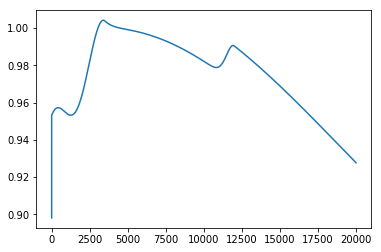

In [108]:
# Plot formant_gauss function
arr = np.arange(0,20000)
arr_gauss = np.zeros(len(arr))
a1, a2, a3, f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, B = return_params("SH")
for i in range(0, len(arr)):
    arr_gauss[i] = formant_gauss(f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, a1, a2, a3, 1.0, 0.2, arr[i])
plt.plot(arr, arr_gauss)

In [13]:
def return_params(vowel):
    # Return the parameters from the params dictionary for vowel
    
    a1 = params[vowel + "a1"]
    a2 = params[vowel + "a2"]
    a3 = params[vowel + "a3"]
    f1 = params[vowel + "f1"]
    f2 = params[vowel + "f2"]
    f3 = params[vowel + "f3"]
    w1l = params[vowel + "w1l"]
    w1r = params[vowel + "w1r"]
    w2l = params[vowel + "w2l"]
    w2r = params[vowel + "w2r"]
    w3l = params[vowel + "w3l"]
    w3r = params[vowel + "w3r"]
    B = params[vowel + "B"]
    
    return a1, a2, a3, f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, B

In [105]:
def interp_params(vowel1, A1, vowel2, A2, tstart, tend, tstep):
    # Interpolate between the parameters of two sounds, named vowel1 and vowel2.
    # tstart: start time
    # tend: end time
    # tstep: time step
    # A1: amplitude of first sound
    # A2: amplitude of second sound
    
    # Extract parameters
    a11 = params[vowel1 + "a1"]
    a21 = params[vowel1 + "a2"]
    a31 = params[vowel1 + "a3"]
    f11 = params[vowel1 + "f1"]
    f21 = params[vowel1 + "f2"]
    f31 = params[vowel1 + "f3"]
    w1l1 = params[vowel1 + "w1l"]
    w1r1 = params[vowel1 + "w1r"]
    w2l1 = params[vowel1 + "w2l"]
    w2r1 = params[vowel1 + "w2r"]
    w3l1 = params[vowel1 + "w3l"]
    w3r1 = params[vowel1 + "w3r"]
    B1 = params[vowel1 + "B"]
    
    a12 = params[vowel2 + "a1"]
    a22 = params[vowel2 + "a2"]
    a32 = params[vowel2 + "a3"]
    f12 = params[vowel2 + "f1"]
    f22 = params[vowel2 + "f2"]
    f32 = params[vowel2 + "f3"]
    w1l2 = params[vowel2 + "w1l"]
    w1r2 = params[vowel2 + "w1r"]
    w2l2 = params[vowel2 + "w2l"]
    w2r2 = params[vowel2 + "w2r"]
    w3l2 = params[vowel2 + "w3l"]
    w3r2 = params[vowel2 + "w3r"]
    B2 = params[vowel2 + "B"]
    
    # Interpolated parameters as a function of time 
    a1f = interp_time(tstart, tend, tstep, a11, a12)
    a2f = interp_time(tstart, tend, tstep, a21, a22)
    a3f = interp_time(tstart, tend, tstep, a31, a32)
    f1f = interp_time(tstart, tend, tstep, f11, f12)
    f2f = interp_time(tstart, tend, tstep, f21, f22)
    f3f = interp_time(tstart, tend, tstep, f31, f32)
    w1lf = interp_time(tstart, tend, tstep, w1l1, w1l2)
    w1rf = interp_time(tstart, tend, tstep, w1r1, w1r2)
    w2lf = interp_time(tstart, tend, tstep, w2l1, w2l2)
    w2rf = interp_time(tstart, tend, tstep, w2r1, w2r2)
    w3lf = interp_time(tstart, tend, tstep, w3l1, w3l2)
    w3rf = interp_time(tstart, tend, tstep, w3r1, w3r2)
    Bf = interp_time(tstart, tend, tstep, B1, B2)
    Af = interp_time(tstart, tend, tstep, A1, A2)
    
    return a1f, a2f, a3f, f1f, f2f, f3f, w1lf, w1rf, w2lf, w2rf, w3lf, w3rf, Af, Bf

In [15]:
def apply_formants(f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, a1, a2, a3, A, B, hfreq, hmag):
    # Apply the multi-Gaussian filter to a list of harmonics
    # hfreq, hmag: frequencies and magnitudes of harmonics
    
    nH = len(hfreq)
    specEnvelope = np.zeros(nH)
    for i in range(0, nH):
        specEnvelope[i] = formant_gauss(f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, a1, a2, a3, A, B, hfreq[i])
        
    hmag_filt = (hmag - base) * specEnvelope + base
    return hmag_filt

In [16]:
def stoc_formants(f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, a1, a2, a3, A, B, white_noise):
    # Apply the multi-Gaussian filter to white noise
    # white_noise: np array of constant values
    
    resample_factor = 100
    x = np.arange(0, int(len(white_noise)/resample_factor))
    stocEnv = np.zeros(len(x), dtype='float')
    for i in range(0, len(x)):
        stocEnv[i] = formant_gauss(f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, a1, a2, a3, A, B, x[i]*resample_factor)
    
    stocEnv = (-base)*stocEnv + base

    return stocEnv

# Putting Things Together

In [106]:
def make_params_list(sound_list, tstep, fade_time):
    # Make a list of parameters with time
    # Given a list of sounds of a particular form
    # Also makes a list of amplitudes for vowels, consonants, and a list of f0s
    # fade_time: time to crossfade between sounds (or fade in or out)
    
    # These are a bit redundant because there is amplitude control elsewhere
    A1 = 1.0
    A2 = 1.
    A = 1.
    
    params_list = []  # List of parameters for multi-Gaussian filter
    Avs = []  # Vowel amplitudes
    Acs = []  # Consonant amplitudes
    f0s = []  # fundamental frequencies
    
    for s in range(0, len(sound_list)):
        # Each s is a particular sound (vowel or consonant)
        sound = sound_list[s][0]       # Sound name (string)
        start = sound_list[s][1]       # Start time
        end = sound_list[s][2]         # End time
        sound_type = sound_list[s][3]  # Vowel or consonant ('v' or 'c')
        amp = sound_list[s][4]         # Amplitude
        startf0 = sound_list[s][5]     # Starting f0
        endf0 = sound_list[s][6]       # Ending f0
        
        a1, a2, a3, f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, B = return_params(sound) # Parameters for multi-gaussian filter
        if (sound_type == 'v'):        # For vowels, set consonant amplitude to zero
            Av = 1.0 * amp 
            Ac = 0.0
        elif (sound_type == 'c'):      # For consonants, set vowel amplitude to zero
            Ac = 1.0 * amp
            Av = 0.0
        else:
            print("Invalid sound type")
            
        f0f = interp_time(start, end, tstep, startf0, endf0)  # Interpolate f0
        counter = 0                                           # Keep track of time over this sound
        #print len(f0f)
        
        if s == 0:
            # For first sound, do a fade-in
            
            Avf = interp_time(0., fade_time, tstep, 0., Av)
            Acf = interp_time(0., fade_time, tstep, 0., Ac)
            
            for t in range(0, int(fade_time/tstep)):
                params_list.append([a1, a2, a3, f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, B])
                Avs.append(Avf[t])
                Acs.append(Acf[t])
                f0s.append(f0f[counter])
                counter += 1
        
        #numsteps = int((end - start - fade_time)/float(tstep))
        #for t in range(int(fade_time/tstep), numsteps):
        #    #print t
        #    #print counter
        #    params_list.append([a1, a2, a3, f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r])
        #    Avs.append(Av)
        #    Acs.append(Ac)
        #    f0s.append(f0f[counter])
        #    counter += 1
        
        if (s != len(sound_list) - 1):
            # For all sounds except last sound
            
            # Do the steady-state part
            numsteps = int((end - start - fade_time)/float(tstep))
            for t in range(int(fade_time/tstep), numsteps):
                params_list.append([a1, a2, a3, f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, B])
                Avs.append(Av)
                Acs.append(Ac)
                f0s.append(f0f[counter])
                counter += 1
            
            # Do a transition (crossfade) into the next sound
            next_sound = sound_list[s+1][0]
            next_sound_type = sound_list[s+1][3]
            amp_next = sound_list[s+1][4]
            #next_start = sound_list[s+1][1]    
            if (next_sound_type == 'v'):
                Av_next = 1.0 * amp_next
                Ac_next = 0.0
            elif (next_sound_type == 'c'):
                Ac_next = 1.0 * amp_next
                Av_next = 0.0
            else:
                print("Invalid next sound type")

            a1f, a2f, a3f, f1f, f2f, f3f, w1lf, w1rf, w2lf, w2rf, w3lf, w3rf, Af, Bf = interp_params(sound, A1, next_sound, A2, 0., fade_time, tstep)
            Avf = interp_time(0., fade_time, tstep, Av, Av_next)
            Acf = interp_time(0., fade_time, tstep, Ac, Ac_next)
            
            numsteps_transition = int(float(fade_time)/float(tstep))
            for t in range(0, numsteps_transition):
                params_list.append([a1f[t], a2f[t], a3f[t], f1f[t], f2f[t], f3f[t], w1lf[t], w1rf[t], w2lf[t], w2rf[t], w3lf[t], w3rf[t], Bf[t]])
                Avs.append(Avf[t])
                Acs.append(Acf[t])
                if counter >= len(f0f):
                    counter = len(f0f) - 1
                f0s.append(f0f[counter])
                counter += 1
                
        else:
            # For the last sound
            
            # Steady-state part
            numsteps = int((end - start - 1.5*fade_time)/float(tstep))
            for t in range(int(fade_time/tstep), numsteps):
                params_list.append([a1, a2, a3, f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, B])
                Avs.append(Av)
                Acs.append(Ac)
                #if counter >= len(f0f):
                #    counter = len(f0f) - 1
                f0s.append(f0f[counter])
                counter += 1
                
            # Fade out
            Avf = interp_time(0., 0.5*fade_time, tstep, Av, 0.)
            Acf = interp_time(0., 0.5*fade_time, tstep, Ac, 0.)
            for t in range(0, int(0.5*fade_time/tstep)):
                params_list.append([a1, a2, a3, f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, B])
                Avs.append(Avf[t])
                Acs.append(Acf[t])
                if counter >= len(f0f):
                    # If the length of f0f happens to not match exactly with the time t
                    counter = len(f0f) - 1
                f0s.append(f0f[counter])
                counter += 1
                
    return params_list, Avs, Acs, f0s

In [145]:
def make_consonants(sound_list, tstep, fade_time, params_list, Acs):
    # Generate white noise and apply multi-gaussian filter
    
    stocEnvs = []
    A0 = 0.7   # Scale input amplitude by this factor
    
    white_noise = np.zeros(fs/2, dtype=float)

    for t in range(0, len(params_list)):
        a1, a2, a3, f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, B = params_list[t]
        Ac = Acs[t]
        #white_noise = np.zeros(fs/2, dtype=float) + (convert_amplitude(Ac))
        
        stocEnv = stoc_formants(f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, a1, a2, a3, Ac*A0, B, white_noise)
        #stocEnv = stoc_formants(f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, a1, a2, a3, A0, B, white_noise)
        stocEnvs.append(stocEnv)
    
    stocEnvs = np.array(stocEnvs)
        
    return stocEnvs

In [144]:
def make_vowels(sound_list, tstep, fade_time, params_list, Avs, f0s):
    # Generate sawtooth wave and apply multi-gaussian filter
    
    hfreqs = []
    hmags = []
    nH = 100
    
    #f0 = 190.
    A0 = 1.
    #hfreq, hmag_saw = saw_gen(f0, A0)
    
    for t in range(0, len(params_list)):
        f0 = f0s[t]
        Av = Avs[t]
        #hfreq, hmag_saw = saw_gen(f0, convert_amplitude(Av), nH)
        hfreq, hmag_saw = saw_gen(f0, A0, nH)

        a1, a2, a3, f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, B = params_list[t]
        #Av = Avs[t]
        hmag = apply_formants(f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, a1, a2, a3, Av, B, hfreq, hmag_saw)
        hfreqs.append(hfreq)
        hmags.append(hmag)
        
    hfreqs = np.array(hfreqs)
    hmags = np.array(hmags)
        
    return hfreqs, hmags

In [20]:
def make_arrays(sound_list, tstep, fade_time):
    # Make consonants and vowels, and return hfreqs, hmags and stocEnvs without generating the audio
    
    base = -120.
    H = 256
    N = 1024
    tstep = H/float(fs)
    
    params_list, Avs, Acs, f0s = make_params_list(sound_list, tstep, fade_time)
    stocEnvs = make_consonants(sound_list, tstep, fade_time, params_list, Acs)
    hfreqs, hmags = make_vowels(sound_list, tstep, fade_time, params_list, Avs, f0s)
    
    return hfreqs, hmags, stocEnvs

In [21]:
def make_sound(sound_list, tstep, fade_time):
    # Make params list, consonants and vowels
    # Then add the resulting sounds (from the vowel and consonant parts) to get the output sound

    base = -120.
    H = 256
    N = 1024
    tstep = H/float(fs)
    
    params_list, Avs, Acs, f0s = make_params_list(sound_list, tstep, fade_time)
    stocEnvs = make_consonants(sound_list, tstep, fade_time, params_list, Acs)
    hfreqs, hmags = make_vowels(sound_list, tstep, fade_time, params_list, Avs, f0s)
    
    y_vowel = SM.sineModelSynth(hfreqs, hmags, np.array([]), N, H, fs)
    y_con = ST.stochasticModelSynth(stocEnvs, H, N)
    
    y = y_vowel + y_con
    y = normalise_sound(y)
    
    return y, hfreqs, hmags, stocEnvs

In [22]:
def make_anim_sound(sound_list, name, dovowel, doconsonant):
    # Make sound and animation
    
    y, hfreqs, hmags, stocEnvs = make_sound(sound_list, tstep, fade_time)
    outputFile_sound = 'output_sounds/voder/' + name + '.wav'
    UF.wavwrite(y, fs, outputFile_sound)
    outputFile_anim = 'output_sounds/voder/' + name + '.mp4'
    ann = do_animation2(hfreqs, hmags, stocEnvs, dovowel, doconsonant)
    ann.save(outputFile_anim, writer = 'ffmpeg')
    #display_animation(ann2)
    #Audio(data=y, rate=fs)
    return y, ann

# Generate Various Sounds

### She Saw Me

In [140]:
fade_time = 0.15
fformmax = 5000

In [149]:
# "She saw me" in monotone
sound_list_monotone = [["SH", 0., 0.45, 'c', 0.8, 190., 190.], ["EE", 0.45, 1., 'v', 0.85, 190., 190.], ["SS", 1., 1.4, 'c', 0.9, 190., 190.], ["AW", 1.4, 2., 'v', 1.0, 190., 190.], ["MM", 2., 2.15, 'v', 0.3, 190., 190.], ["EE", 2.15, 3., 'v', 0.9, 190., 190.]]

/Users/shaomintan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


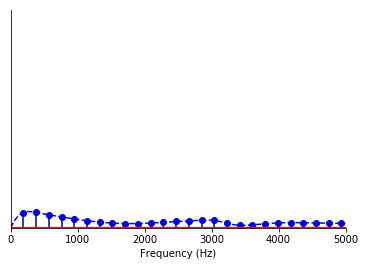

In [152]:
y, ann = make_anim_sound(sound_list_monotone, "monotone", 1, 1)

In [84]:
# Emphasis on saw
sound_list_saw = [["SH", 0., 0.45, 'c', 0.8, 190., 190.], ["EE", 0.45, 0.8, 'v', 0.85, 190., 192.], ["SS", 0.8, 1.2, 'c', 0.9, 200., 200.], ["AW", 1.2, 1.85, 'v', 1.0, 210., 180.], ["MM", 1.85, 2., 'v', 0.3, 200., 195.], ["EE", 2., 2.75, 'v', 0.9, 195., 170.]]

/Users/shaomintan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


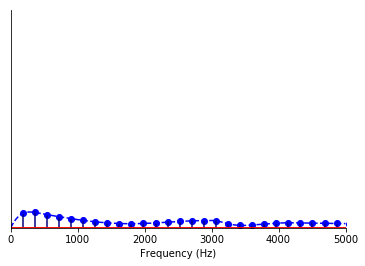

In [85]:
y, ann = make_anim_sound(sound_list_saw, "saw", 1, 1)

In [86]:
# Emphasis on me
sound_list_me = [["SH", 0., 0.45, 'c', 0.8, 190., 190.], ["EE", 0.45, 0.8, 'v', 0.9, 190., 191.], ["SS", 0.8, 1.2, 'c', 0.9, 190., 190.], ["AW", 1.2, 1.65, 'v', 1.0, 182., 183.], ["MM", 1.65, 1.75, 'v', 0.3, 205., 205.], ["EE", 1.75, 2.55, 'v', 0.9, 205., 190.]]

/Users/shaomintan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


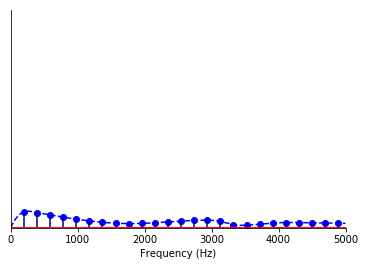

In [87]:
y, ann = make_anim_sound(sound_list_me, "me", 1, 1)

In [88]:
# Emphasis on she
sound_list_she = [["SH", 0., 0.45, 'c', 0.8, 200., 200.], ["EE", 0.45, 0.95, 'v', 0.92, 215., 190.], ["SS", 0.95, 1.3, 'c', 0.9, 195., 195.], ["AW", 1.3, 1.75, 'v', 1.0, 197., 190.], ["MM", 1.75, 1.85, 'v', 0.2, 195., 190.], ["EE", 1.85, 2.45, 'v', 0.85, 190., 170.]]

/Users/shaomintan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


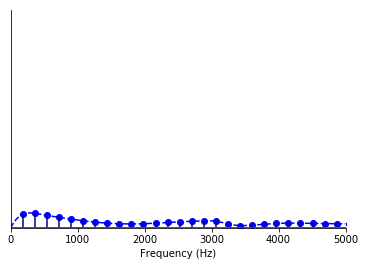

In [89]:
y, ann = make_anim_sound(sound_list_she, "she", 1, 1)

### Vowels

In [153]:
vlen = 2.
fade_time = 0.25
f0 = 190.
fformmax = 5000
sound_list_vowels = [["NO", 0., vlen, 'v', 0.7, f0, f0], ["AA", vlen, 2*vlen, 'v', 1.0, f0, f0], ["EE", 2*vlen, 3*vlen, 'v', 0.85, f0, f0], ["AW", 3*vlen, 4*vlen, 'v', 0.9, f0, f0], ["OO", 4*vlen, 5*vlen, 'v', 0.9, f0, f0]]
#sound_list_vowels = [["NO", 0., vlen, 'v', 1.0, f0, f0]]
#sound_list_vowels = [["NO", 0., vlen, 'v', 0.7, f0, f0], ["AA", vlen, 2*vlen, 'v', 1.0, f0, f0]]

/Users/shaomintan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


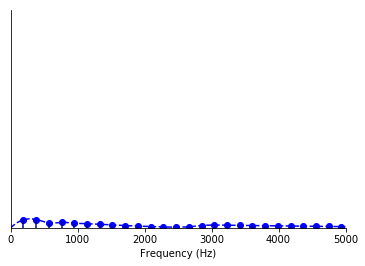

In [154]:
y, ann = make_anim_sound(sound_list_vowels, "vowels", 1, 0)
#Audio(data=y, rate=fs)

[1.0, 0.0, 0.0, 300.0, 15000.0, 20000.0, 2000.0, 10000.0, 5000.0, 5000.0, 5000.0, 5000.0, 0.0]


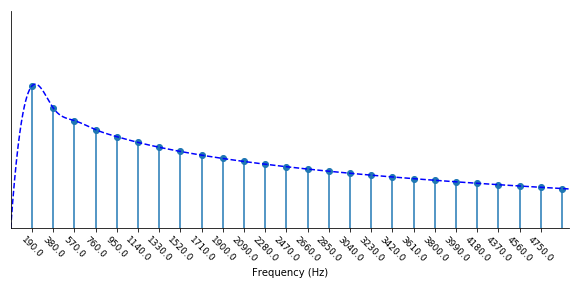

In [159]:
params_list, Avs, Acs, f0s = make_params_list(sound_list_vowels, tstep, fade_time)
#print Avs
#print params_list
#stocEnvs = make_consonants(sound_list, tstep, fade_time, params_list, Acs)
print params_list[158]
hfreqs, hmags = make_vowels(sound_list_vowels, tstep, fade_time, params_list, Avs, f0s)
spline_plot(hfreqs[168,:], hmags[168, :])

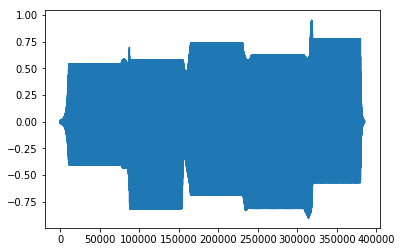

In [157]:
plt.plot(np.arange(len(y)), y)

### Consonants

In [181]:
vlen = 2.
fade_time = 0.25
f0 = 190.
fformmax = 20000
sound_list_consonants = [["NO", 0., vlen, 'c', 0.2, f0, f0], ["SH", vlen, 2*vlen, 'c', 1.46, f0, f0], ["SS", 2*vlen, 3*vlen, 'c', 1.46, f0, f0]]

/Users/shaomintan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


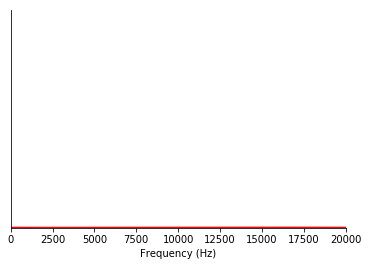

In [182]:
y, ann = make_anim_sound(sound_list_consonants, "consonants", 0, 1)

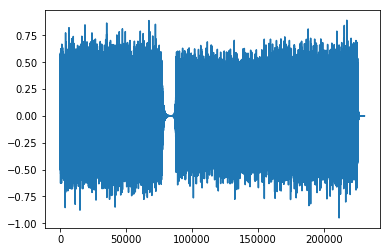

In [183]:
plt.plot(np.arange(len(y)), y)

Changes for the future: In make_vowel and make_consonant, make it so that the amplitude from sound_list modifies the source amplitude (sawtooth or white noise), rather than the formant_gauss function amplitude.  Otherwise, when B = 0, the input amplitude has no effect.  (Already tried doing this, but there's a bug somewhere that hasn't been caught, so reverted back to the old way.)

# Analyse Recorded Sounds

In [184]:
# Parameters for FFT and harmonic model

window='blackman'
M=4001
N=4096
H = 256
t=-120
minSineDur=0
nH=150
minf0=100
maxf0=300
f0et=7
harmDevSlope=0.01

In [185]:
inputFile='sounds/vowels/MM.wav'

In [186]:
# read input sound
fs, x = UF.wavread(inputFile)
L = len(x)

start = 1000
x = x[start : start+M]
# compute analysis window
w = get_window(window, M)

mX, pX = DFT.dftAnal(x, w, N)

/Users/shaomintan/anaconda/lib/python2.7/site-packages/scipy/signal/signaltools.py:2230: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = zeros(newshape, 'D')


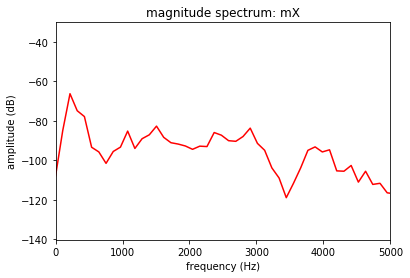

In [187]:
# Plot smoothed magnitude spectrum

fact = 20.
mY = resample(mX, N/fact)
plt.plot(float(fs/2)*np.arange(mY.size)/(float(N)/fact), mY, 'r')
plt.axis([0, 5000, min(mX), max(mX)])
plt.title ('magnitude spectrum: mX')
plt.ylabel('amplitude (dB)')
plt.xlabel('frequency (Hz)')

[0, 5000, -140.20641122350003, -30.223722003447648]

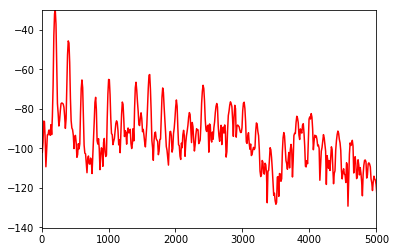

In [188]:
# Plot magnitude spectrum

plt.plot(float(fs)*np.arange(mX.size)/(float(N)), mX, 'r')
plt.axis([0, 5000, min(mX), max(mX)])

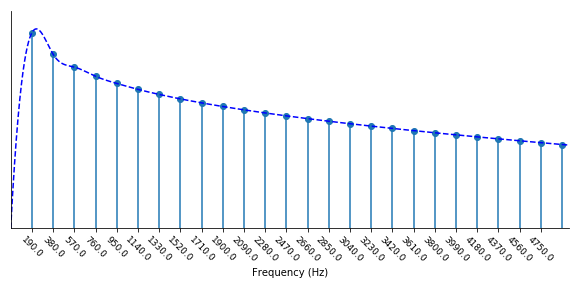

In [190]:
# Test out some parameters for the multi gaussian filter and plot result
base = -120
nH = 116
hfreq_saw, hmag_saw = saw_gen(f0, 30., 100)
hmag_test = apply_formants(300., 10000., 20000., 2000., 10000., 5000., 5000., 5000., 10000., 1., 0., 0., 1.0, 1.0, hfreq_saw, hmag_saw)
spline_plot(hfreq_saw, hmag_test)

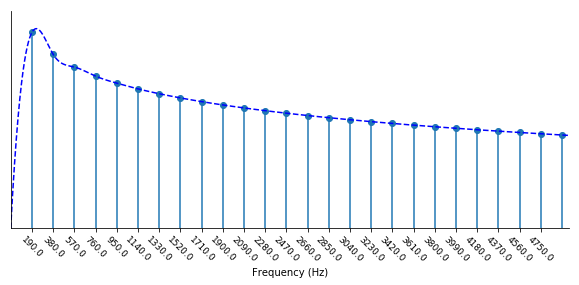

In [191]:
spline_plot(hfreq_saw, hmag_saw)

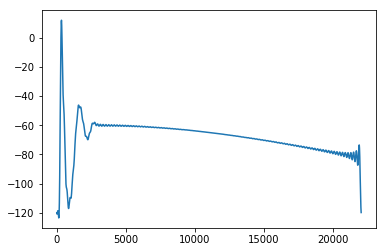

In [196]:
# Test out some parameters for multigaussian filter and test result (non-harmonic sound)
white_noise = np.zeros(fs/2, dtype=float)
stocenv_test = stoc_formants(300., 1600., 2700., 50., 200., 300., 400., 400., 20000., 1., 0.6, 0.5, 1.0, 1.0, white_noise)
#hmag_test = stoc_formants(750., 3000., 3700., 700., 1100., 500., 250., 250., 900., 1., 0.8, 0.7, 1.0, white_noise)
#print stocenv_test.shape

plt.plot(np.arange(fs/2), resample(stocenv_test, fs/2))

# Old Functions

In these old functions, consonants and vowels are made separately.  For each entry in sound list, either a white noise source or a sawtooth is generated, and the filter for the sound is applied.  Then a crossfade is applied between adjacent sounds.  This sounds rather abrupt, because the filters of the two sounds have different frequencies.  In the new version above, there is one continuously changing filter over the length of the whole sound, which is calculated by interpolating between the filter frequencies of adjacent sounds.  The source changes between white noise and sawtooth depending on the type of sound.

In [742]:
def make_consonant(sound_list, tstep, fade_time_in, fade_time_out):
    stocEnvs = []
    
    for c in range(0, len(sound_list)):
        con = sound_list[c][0]
        start = sound_list[c][1]
        end = sound_list[c][2]
        
        a1, a2, a3, f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r = return_params(con)
        
        f0 = 195.
        A0 = 0.7
        base = -120.
        top = 0.
        
        white_noise = np.zeros(fs/2, dtype=float)
        stocEnv = stoc_formants(f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, a1, a2, a3, A0, white_noise)
        
        A_func_in = interp_time(0, fade_time_in, tstep, base, top)
        #print A_func_in
        A_func_out = interp_time(0, fade_time_out, tstep, top, base)
        
        num_fadesteps_in = int(fade_time_in/tstep)
        num_fadesteps_out = int(fade_time_out/tstep)
        
        numsteps = int((end - start)/float(tstep))
        for t in range(0, numsteps):
            add = 0.
            if (t < num_fadesteps_in):
                add = A_func_in[t]
                #print t
                #print add
            elif (t > numsteps-num_fadesteps_out):
                add = A_func_out[t-(numsteps-num_fadesteps_out)]
            #else:
            #    add = 0
            
            #stocEnv = stoc_formants(f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, a1, a2, a3, A, white_noise)
            stocEnvs.append(stocEnv + add)
            #print add
            #print stocEnv
            #print(stocEnv + add)
            
    stocEnvs = np.array(stocEnvs)
            
    return stocEnvs

In [708]:
def make_freqs_mags(sound_list, tstep):
    
    hfreqs = []
    hmags = []
    
    for v in range(0, len(sound_list)):
        vowel = sound_list[v][0]
        start = sound_list[v][1]
        end = sound_list[v][2]
        
        a1, a2, a3, f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r = return_params(vowel)
        
        f0 = 195.
        A0 = 1.1
        A = 1.1
        A1 = 1.1
        A2 = 1.1
        
        hfreq, hmag_saw = saw_gen(f0, A0)
        hmag = apply_formants(f1, f2, f3, w1l, w1r, w2l, w2r, w3l, w3r, a1, a2, a3, A, hfreq, hmag_saw)
        
        numsteps = int((end - start)/float(tstep))
        for t in range(0, numsteps):
            hfreqs.append(hfreq)
            hmags.append(hmag)
        
        if (v != len(sound_list) - 1):
        
            next_vowel = sound_list[v+1][0]
            next_start = sound_list[v+1][1]        

            a1f, a2f, a3f, f1f, f2f, f3f, w1lf, w1rf, w2lf, w2rf, w3lf, w3rf, Af = interp_params(vowel, A1, next_vowel, A2, end, next_start, tstep)

            numsteps_transition = int((next_start - end)/float(tstep))
            for t in range(0, numsteps_transition):
                hmag = apply_formants(f1f[t], f2f[t], f3f[t], w1lf[t], w1rf[t], w2lf[t], w2rf[t], w3lf[t], w3rf[t], a1f[t], a2f[t], a3f[t], Af[t], hfreq, hmag_saw)
                hmags.append(hmag)
                hfreqs.append(hfreq)
    
    hfreqs = np.array(hfreqs)
    hmags = np.array(hmags)
    
    return hfreqs, hmags

In [735]:
def make_combined_sound(sound_list_con, sound_list_vowel, tstep, fade_time_in, fade_time_out):

    H = 256
    N = 1024
    tstep = H/float(fs)
    
    hfreqs, hmags = make_freqs_mags(sound_list_vowel, tstep)
    stocEnvs = make_consonant(sound_list_con, tstep, fade_time_in, fade_time_out)
    
    y_vowel = SM.sineModelSynth(hfreqs, hmags, np.array([]), N, H, fs)
    y_con = ST.stochasticModelSynth(stocEnvs, H, N)
    print y_vowel
    print y_con
    
    len_to_cut = np.min((len(y_vowel), len(y_con)))
    
    y = y_vowel[:len_to_cut] + y_con[:len_to_cut]
    #y = y_vowel[:len_to_cut]
    
    return y

In [744]:
sound_list_con = [["SH", 0., 0.6], ["DUD", 0.6, 1.]]

In [745]:
sound_list_vowel = [["DUD", 0., 0.0], ["EE", 0.4, 1.]]

In [746]:
y = make_combined_sound(sound_list_con, sound_list_vowel, tstep, 0.3, 0.1)
Audio(data=y, rate=fs)

[  7.33560193e-06  -2.12418471e-05  -9.90878380e-06 ...,   2.88050585e-03
   3.82173461e-03   4.67463303e-03]
[ -2.80218910e-10  -5.74649826e-10  -5.27698858e-10 ...,   1.01777182e-13
  -1.21741120e-13   2.44918897e-13]


# Scratch

In [ ]:
const - (A * (const - B*gauss))
= (1-A)*const + B*A*gauss